In [5]:
import os
import numpy as np
import torch
import torchvision
import PIL
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import copy
#
import config.config_flags as Config
import data_load.data_provider as dp
import runner as runner
import utils.task_helper as th
import utils.helper as helper
import datasetconf as DC
import TaskClass as TaskClass
import Task as Task
import TestNets as TestNets
#
_ = importlib.reload(Config)
_ = importlib.reload(th)
_ = importlib.reload(dp)
_ = importlib.reload(runner)
_ = importlib.reload(helper)
_ = importlib.reload(DC)
_ = importlib.reload(TaskClass)
_ = importlib.reload(Task)
_ = importlib.reload(TestNets)

In [6]:
# Create Task objects

#Set tensor device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Generate Task DB or load from filesystem
print("Generating tasks and compute their alpha weights")
runner.populate_db()

#Perform top-m filtering
print("Filtering top-m alpha weights and training tasks")
alpha_weights, train_db = runner.top_m_filtering()

#Get target task from filesystem
test_path = helper.get_task_dataset_path("test")
test_db = runner.unpickle(test_path)

#Get train data embeddings
print("Fetching train embeddings")
train_provider = dp.DataProvider("train", debug=False, verbose=False)
train_tr_size = Config.TRAINING_NUM_OF_EXAMPLES_PER_CLASS
train_val_size = Config.VALIDATION_NUM_OF_EXAMPLES_PER_CLASS
print("Generating training tasks")
train_tasks = th.generate_tasks(train_db, train_provider, train_tr_size, train_val_size, device)

#Get train data embeddings
print("Fetching test embeddings")
test_provider = dp.DataProvider("test", debug=False, verbose=False)
test_tr_size = 0
test_val_size = Config.TEST_VALIDATION_NUM_OF_EXAMPLES_PER_CLASS
print("Generating test tasks")
test_tasks = th.generate_tasks(test_db, test_provider, test_tr_size, test_val_size, device)

Generating tasks and compute their alpha weights
Filtering top-m alpha weights and training tasks
Fetching train embeddings
Path fetched: ../embeddings\tieredImageNet\center\train_embeddings.pkl
100%|██████████| 100/100 [00:03<00:00, 26.30it/s]
Fetching test embeddings
Path fetched: ../embeddings\tieredImageNet\center\test_embeddings.pkl
100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


In [2]:
task1 = Task.create_task_given(
    task_friendly_name='Task1',
    dataset_name='boat',
    class_names=['Gondola', 'Lanciafino10m', 'Motopontonerettangolare'], #n-way
    len_support_dataset=3, #k-shot
    len_query_dataset=2,   #k-shot
    transformer=torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])]),
    img_size=224,
    start_class_id=0)
task1.reset_train_session()
#
task2 = Task.create_task_given(
    task_friendly_name='Task2',
    dataset_name='boat',
    class_names=['Raccoltarifiuti', 'Water'],
    len_support_dataset=5,
    len_query_dataset=2,
    transformer=torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])]),
    img_size=224,
    start_class_id=3)
task2.reset_train_session()
#
TASKS = [task1, task2]
LEN_CLASSES = sum(len(task.task_classes) for task in TASKS)
CLASSES_NAMES = [taskclass.class_friendly_name for task in TASKS for taskclass in task.task_classes]
NUM_IN_CHANNELS = 3 # RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor([1, 0, 1, 0])
torch.Size([15, 3, 224, 224])
torch.Size([15])


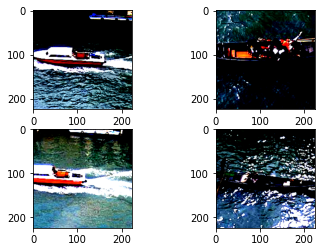

In [3]:
plt.subplot(221)
plt.imshow(task1.supp_train[0].permute(1, 2, 0))
plt.subplot(222)
plt.imshow(task1.supp_train[1].permute(1, 2, 0))
plt.subplot(223)
plt.imshow(task1.supp_train[2].permute(1, 2, 0))
plt.subplot(224)
plt.imshow(task1.supp_train[3].permute(1, 2, 0))
#
print(task1.supp_targets[:4])
print(task1.supp_train.shape)
print(task1.supp_targets.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor([4, 4, 3, 4])
torch.Size([20, 3, 224, 224])
torch.Size([20])


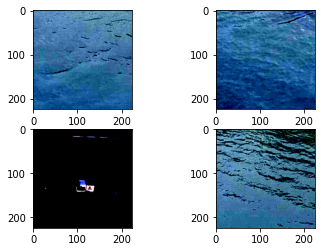

In [4]:
plt.subplot(221)
plt.imshow(task2.supp_train[0].permute(1, 2, 0))
plt.subplot(222)
plt.imshow(task2.supp_train[1].permute(1, 2, 0))
plt.subplot(223)
plt.imshow(task2.supp_train[2].permute(1, 2, 0))
plt.subplot(224)
plt.imshow(task2.supp_train[3].permute(1, 2, 0))
#
print(task2.supp_targets[:4])
print(task2.supp_train.shape)
print(task2.supp_targets.shape)

In [5]:
test_net = TestNets.SimpleCNN224x224(n_channels_in=NUM_IN_CHANNELS, n_classes=LEN_CLASSES)
loss_function = torch.nn.CrossEntropyLoss()
#
lr = 0.001
meta_lr = 0.001
#
optimiser = lambda x, g: x - lr * g
meta_optimiser = torch.optim.Adam(test_net.parameters(), lr=meta_lr)

In [7]:
from collections import OrderedDict
import copy

# NOTE: this only does one epoch of SGD per support dataset: more epochs?

test_net.train()

for _ in range(10):
    backup_named_parameters = test_net.named_parameters
    outer_loss = 0
    meta_optimiser.zero_grad()
    test_net.zero_grad()
    for task in TASKS:
        #
        supp_train_inner_loss = loss_function(test_net(task.supp_train), task.supp_targets)
        #
        test_net.zero_grad()
        grads = torch.autograd.grad(supp_train_inner_loss, test_net.parameters(), create_graph=True)
        #
        named_params = OrderedDict()
        for (pname, param), grad in zip(test_net.named_parameters(), grads):
            named_params[pname] = optimiser(param, grad)
        #
        test_net.named_parameters = named_params
        query_tr_inner_loss = loss_function(test_net(task.query_train), task.query_targets)
        test_net.named_parameters = backup_named_parameters
        #
        outer_loss += query_tr_inner_loss # mul with alpha
    #
    outer_loss.backward() # add final loss here L(Alg(theta, Dtr), Dval)
    meta_optimiser.step()

In [8]:
from sklearn.metrics import classification_report
test_net.eval()
#
for task in TASKS:
    task.reset_test_session()
    preds_softmax = test_net(task.test_train)
    preds = torch.argmax(preds_softmax, dim=1)
    correct = torch.sum(preds == task.test_targets).item()
    print(task.task_friendly_name, correct * 100 / task.test_targets.shape[0])
    # print(classification_report(task.test_targets, preds, target_names=CLASSES_NAMES, labels=range(LEN_CLASSES)))

Task1 7.6923076923076925
Task2 76.5375854214123


In [9]:
test_net.train()

for _ in range(10):
    backup_named_parameters = test_net.named_parameters
    outer_loss = 0
    for task in TASKS:
        meta_optimiser.zero_grad()
        loss = loss_function(test_net(task.supp_train), task.supp_targets)
        loss.backward()
        meta_optimiser.step()
        meta_optimiser.zero_grad()
        loss = loss_function(test_net(task.query_train), task.query_targets)
        loss.backward()
        meta_optimiser.step()

In [ ]:
task = Task('ajfdsahsldf')
for class_id in range(...)
    taskclass = TaskClass(class_id)
    task.add_task_class(taskclass)
    #
    taskclass.set_support_dataset(list_of_embeddings)
    taskclass.set_query_dataset()
    
task.reset_train_session() # create the shuffled training tensor